In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import random
import ipywidgets

### 3. Rewrite the sloshing model as a system of ordinary differential equations (ODEs) based on equation (4) from the paper

The equation (4) from the paper is the following.
$$u'' + [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(u - \frac{\varepsilon^2 u^3}{6}\Big) = 0$$

Solving for $u''$ we have the following equation.
$$u'' = - [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(u - \frac{\varepsilon^2 u^3}{6}\Big)$$

Let $y_1 = u, y_2 = u'$,  we can write the sloshing model as the following system of ODE.

$$
\begin{cases}
    \frac{dy_1}{d\tau} = y_2 \\
    \frac{dy_2}{d\tau} = [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(y_1 - \frac{\varepsilon^2 y_1^3}{6}\Big)
\end{cases}
$$

The following cell encapsulates the system as a Python function `vertical_motion`. Refer to the function’s comments for more details.

In [3]:
def vertical_motion(tau, system, omega, lambd, epsilon):
    """
    Ordinary Differential Equation from the paper labeled as (4)
    As a system of first-grade ordinary differential equations
    
    Args:
        tau: parameter of the ordinary differential equation (4)
        system: [y1, y2]

    Return
        [dy1/d_tau, d_y2/d_tau]
    """
    y1, y2 = system

    dy1dtau = y2
    dy2dtau = - (1 + epsilon * lambd * omega**2 * np.cos(omega * tau)) * (y1 - epsilon**2 * y1**3/6) 

    return np.array([dy1dtau, dy2dtau])

### 4. Solve the system numerically using solve ivp from SciPy for two different sets of parameters.

In order to solve the system numerically we define the following parameters for the model:

#### Relative dimensionless frequency $\Omega$
In [1], $\Omega$ is defined as the ratio of the excitation frequency $\omega$ to the natural frequency $\omega_0$. In this context, we define $\omega_{0}$ as the natural frequency of the cup in the sloshing model, denoted as $f_{cup}$, and $\omega$ as the step frequency, denoted as $f_{step}$.
$$\Omega=\frac{\omega}{\omega_{0}}\approx \frac{f_{step}}{f_{cup}}$$

##### Natural frequency $f_{cup}$
The natural frequency $f_{cup}$ represents the frequency at which the liquid inside the cup is going to oscillate  naturally when it is perturbed. This frequency depends on the physical properties of the cup, this value is usually in the range $[2.6, 4.3]$ Hz [1].

> There are multiple algorithms to calculate $f_{cup}$ for a given cup [2].

##### Step frequency $f_{step}$
The step frequency $f_{step}$ represents the pace at which the person carrying the cup is walking, measured in steps per second. It acts as the external excitation that induces the motion of the liquid in the cup. This value is usually in the range $[1, 2.5]$ Hz [1].

> When $\Omega \approx 1$ the frequencies produce a resonance that amplifies the liquid's oscillations making the risk of spilling higher.

#### Ratio between the effective length and amplitude of oscillation $\lambda$
The parameter $\lambda$ quantifies the rate of change of the pendulum's (cup of coffee) effective length in relation to its original length induced by the vertical movement of its pivot [1].
- A small value of $\lambda$ implies that the vertical amplitude of oscillation is small compared to the original length, suggesting that the pendulum's effective length remains nearly constant during the oscillation. This reduces the likelihood of resonance, making the system more stable [2].
- For high values of $\lambda$, the oscillation response becomes complex and unstable.

#### Bookkeeping parameter $\varepsilon$
This parameter is used in the method of multiple scales and the method of averaging as a perturbation parameter. It expands the solution into a series, with each term representing a different order of magnitude of the nonlinear influences [2].
- A small value of $\varepsilon$ implies that the nonlinearities are weak and can be treated as perturbations to the linear system.

#### Dimensionless Time $\tau$
Dimensionless time is defined as $\tau = t\omega$, where $\omega$ represents the frequency of the movement and $t$ the time variable. With $\tau$, the analysis is conducted in terms of oscillation cycles rather than absolute time units.

----

Now we define 2 sets of parameters in the code

> We are only varying the values for $\Omega, \lambda, \varepsilon$ in the sets of parameters. Although we are defining again values for $y_{1_0}$ and $y_{2_0}$ (initial conditions), and $\tau_l, \tau_r$, where $(\tau_l, \tau_r)$ corresponds to the domain where we are going to integrate

In [4]:
# Parameters as list
omega = [2, 1]
lambd = [0.1, 0.2]
epsilon = [0.2, 0.5]
y1_0 = [0.5, 0.5]
y2_0 = [0.5, 0.5]

# (tau_l, tau_r) is the domain where we are going to integrate
tau_l = [0, 0] 
tau_r = [50, 50]

for i in range(2):
    print(f"\n===== Parameter Set {i + 1} =====")
    print(f"Omega     : {omega[i]}")
    print(f"Lambda    : {lambd[i]}")
    print(f"Epsilon   : {epsilon[i]}")
    print(f"y1_0      : {y1_0[i]}")
    print(f"y2_0      : {y2_0[i]}")
    print(f"tau_l     : {tau_l[i]}")
    print(f"tau_r   : {tau_r[i]}")
    print("=" * 30)


===== Parameter Set 1 =====
Omega     : 2
Lambda    : 0.1
Epsilon   : 0.2
y1_0      : 0.5
y2_0      : 0.5
tau_l     : 0
tau_r   : 50

===== Parameter Set 2 =====
Omega     : 1
Lambda    : 0.2
Epsilon   : 0.5
y1_0      : 0.5
y2_0      : 0.5
tau_l     : 0
tau_r   : 50


In [5]:
def quick_summary_data(tau, y1, y2, m = 5):
    """
    Prints a quick summary for the given data(from a numerical solution) of the sloshing model by selecting a random sample of points.

    Args:
        tau (list or array-like): A sequence of numerical values representing the tau values.
        y1 (list or array-like): A sequence of numerical values representing the y1 function values.
        y2 (list or array-like): A sequence of numerical values representing the y2 function values.
        m (int, optional): The number of random samples to display. Default is 5.

    Returns:
        None: The function prints a formatted table but does not return any value.
    """
    
    n = len(tau) # # Number of data points
    random_indexes = sorted(random.sample(range(n), m))

    # Print table header
    print(f"{'Index':<5} {'tau':<10} {'y1':<10} {'y2':<10}")
    print("-" * 35)

    # Print selected random rows
    for i in random_indexes:
        print(f"{i:<5} {tau[i]:<10.4f} {y1[i]:<10.4f} {y2[i]:<10.4f}")


def solve_numerically(y1_0, y2_0, tl, tr, omega, lambd, epsilon, summary=False):
    """
    Solves the sloshing model numerically with set of parameters[index].

    Args:
        index (int): Index specifying which set of initial conditions and parameters to use.
        summary (bool, optional): If True, prints a summary of the numerical solution. Default is False.

    Returns:
        tuple: (tau, y1, y2)
            - tau (numpy.ndarray): tau values of the numerical solution.
            - y1 (numpy.ndarray): y1 function values of the numerical solution.
            - y2 (numpy.ndarray): y2 function values of the numerical solution.
    """
    initial_conditions = [y1_0, y2_0]

    # The system expect this parameters
    parameters = (omega, lambd, epsilon)

    # SOLVE DIFFERENTIAL EQUATIONS
    # Use SciPy solve_ivp to numerically solve the system of ODEs
    sol_scipy = scipy.integrate.solve_ivp(
        vertical_motion, # Function defining the system of ODEs
        (tl, tr), # Domain
        initial_conditions, 
        args=(parameters), # The system depends of extra parameters like Omega
    ) 
    
    # Extract solution components
    tau = sol_scipy.t
    y1 = (sol_scipy.y)[0]
    y2 = (sol_scipy.y)[1]

    # If summary is enabled, print a quick summary of the solution
    if summary:
        quick_summary_data(tau, y1, y2)

    # Return the computed values as a tuple
    return (tau, y1, y2)
    

Solve for first set of parameters

In [6]:
tau, y1, y2 = solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_r[0], omega[0], lambd[0], epsilon[0], summary=True)

Index tau        y1         y2        
-----------------------------------
13    11.5317    -0.1488    0.5386    
18    16.3132    -0.5016    -0.0844   
30    27.6541    -0.0532    -0.4040   
32    29.5243    -0.3536    0.1725    
33    30.4183    -0.0947    0.3710    


Solve for second set of parameters

In [7]:
tau, y1, y2 = solve_numerically(y1_0[1], y2_0[1], tau_l[1], tau_r[1], omega[1], lambd[1], epsilon[1], summary=True)

Index tau        y1         y2        
-----------------------------------
28    26.3286    0.6970     -0.1791   
31    29.2556    -0.7481    -0.0356   
37    35.1458    -0.6686    -0.3301   
44    42.0003    -0.7564    0.0136    
51    48.7867    -0.6813    0.3312    


### 5. Present and analyze the numerical results using well-labeled graphs. Clearly document the parameter values used and discuss their impact on the sloshing behavior.

In [8]:
def graph_results(tau, y1, y2):
    """
    Plots the numerical solution of sloshing model, displaying the function and its derivative.

    Args:
        tau (numpy.ndarray): tau values of the numerical solution.
        y1 (numpy.ndarray): y1 values (solution of the function).
        y2 (numpy.ndarray): y2 values (derivative of the function).

    Returns:
        None: Displays the plots but does not return any values.
    """

    # Create two subplots in a single row to visualize the function and its derivative
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot: Graph of y1 (function u(tau))
    axes[0].plot(tau, y1, label="u(tau) (scipy solution)")
    axes[0].set_xlabel("tau")
    axes[0].set_title("Vertical motion of the pivot: Method of Averaging")
    axes[0].legend()
    
    # First subplot: Graph of y1 (function u(tau))
    axes[1].plot(tau, y2, label="u'(tau) (scipy solution)")
    axes[1].set_xlabel("tau")
    axes[1].set_title("Vertical motion of the pivot: Method of Averaging")
    axes[1].legend()

    plt.tight_layout() # Adjust subplot layout to prevent overlapping labels

    # Display the plots
    plt.show()

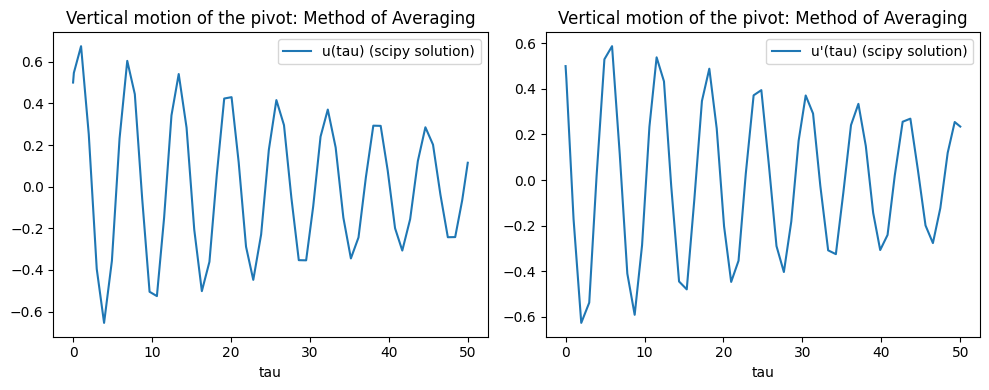

In [9]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_r[0], omega[0], lambd[0], epsilon[0], summary=False))

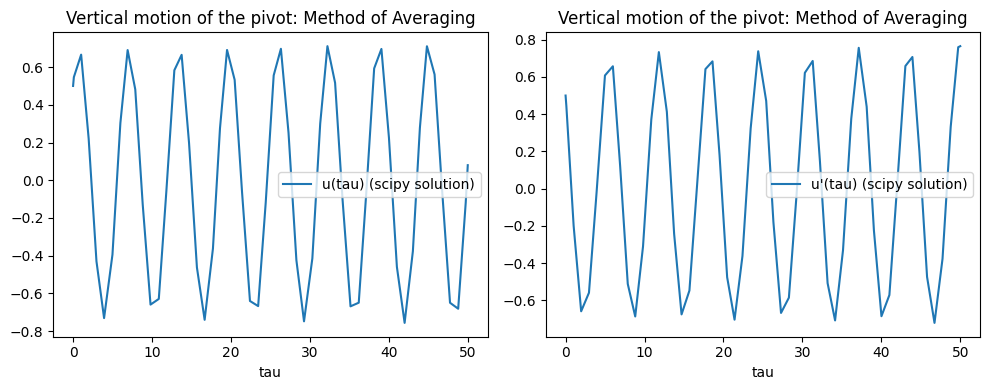

In [10]:
graph_results(*solve_numerically(y1_0[1], y2_0[1], tau_l[1], tau_r[1], omega[1], lambd[1], epsilon[1], summary=False))

**Interactive Graph**
> It is not available from the Github's preview

In [ ]:
def interactive_plot(y1_0=y1_0[0], y2_0=y2_0[0], tl=tau_l[0], tr=tau_r[0], omega=omega[0], lambd=lambd[0], epsilon=epsilon[0]):
    initial_conditions = [y1_0, y2_0]
    parameters=(omega, lambd, epsilon)

    sol_scipy = scipy.integrate.solve_ivp(
        vertical_motion,
        (tl, tr), 
        initial_conditions, 
        args=(parameters), 
    ) 
    
    if tl > tr:
        return
    
    x = sol_scipy.t
    y = (sol_scipy.y)[0]
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label='u(tao) (scipy solution)')
    plt.xlabel('tao')
    plt.title('Vertical motion of the pivot: Method of Averaging (Interactive Graph)')
    plt.legend()
    plt.grid()
    plt.show()

# Interactive widgets.
display(
    ipywidgets.interact(
        interactive_plot, 
        y1_0=(0.1, 5.0, 0.1), 
        y2_0=(0.1, 5.0, 0.1),
        tl  =(0.1, 100, 1),
        tr  =(0.1, 500, 1),
        omega=(0.5, 4, 0.5),
        lambd=(0.1, 2, 0.1),
        epsilon=(0.0, 1, 0.1)
    )
)

interactive(children=(FloatSlider(value=0.5, description='y1_0', max=5.0, min=0.1), FloatSlider(value=0.5, des…

<function __main__.interactive_plot(y1_0=0.5, y2_0=0.5, tl=0, tr=50, omega=2, lambd=0.1, epsilon=0.2)>

**Discussion about the parameters and their impact on the sloshing behavior**

Remember that the equation is
$$u'' + [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(u - \frac{\varepsilon^2 u^3}{6}\Big) = 0$$

In the following celds we are going to experiment for different slighter variations in each variable from the 1st parameter set, to support the conclusions

In [12]:
# Parameters for the following experiments.
tau_max_big = 100
tau_max_small = 6

#### Relative dimensionless frequency $\Omega$

Remember that $\Omega$ is defined as the ratio of the excitation frequency to the natural frequency. Consider the following experiments
.

##### $\Omega = 1$

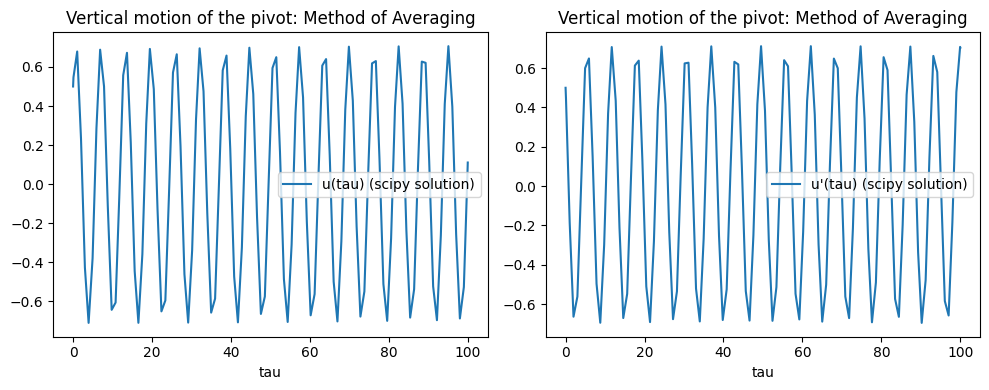

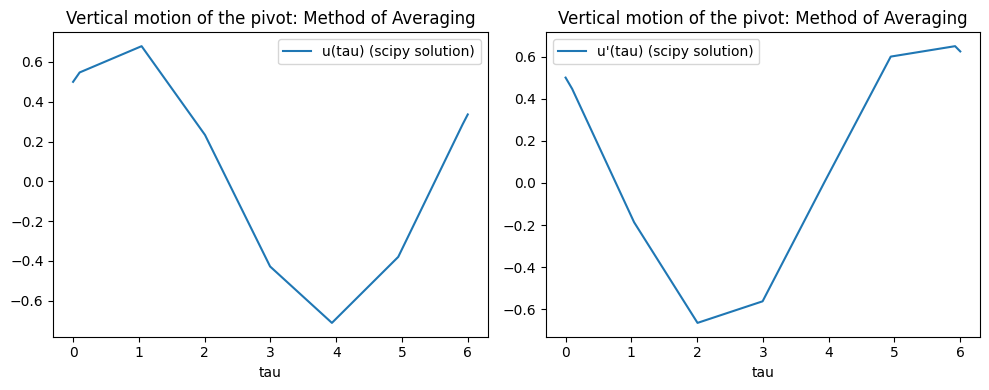

In [13]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, 1, lambd[0], epsilon[0], summary=False))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, 1, lambd[0], epsilon[0], summary=False))

##### $\Omega = 2$

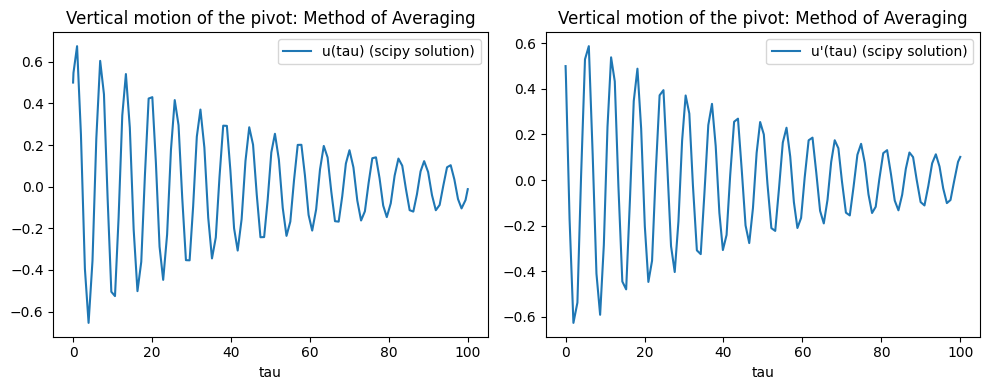

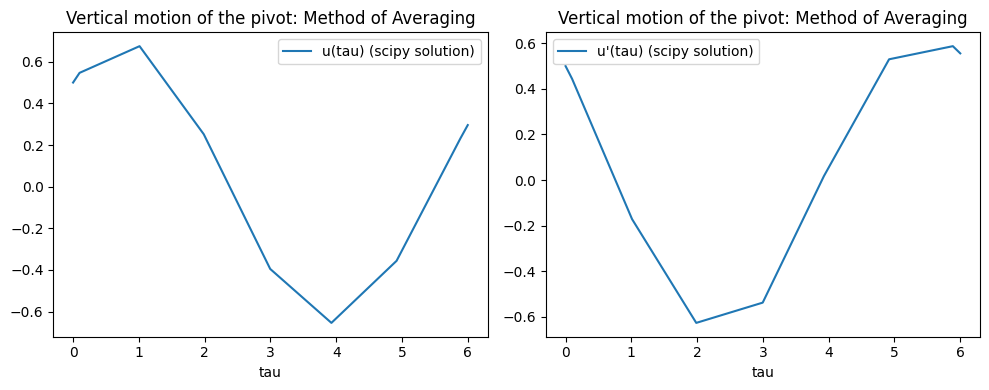

In [14]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, 2, lambd[0], epsilon[0]))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, 2, lambd[0], epsilon[0]))

##### $\Omega = 3$

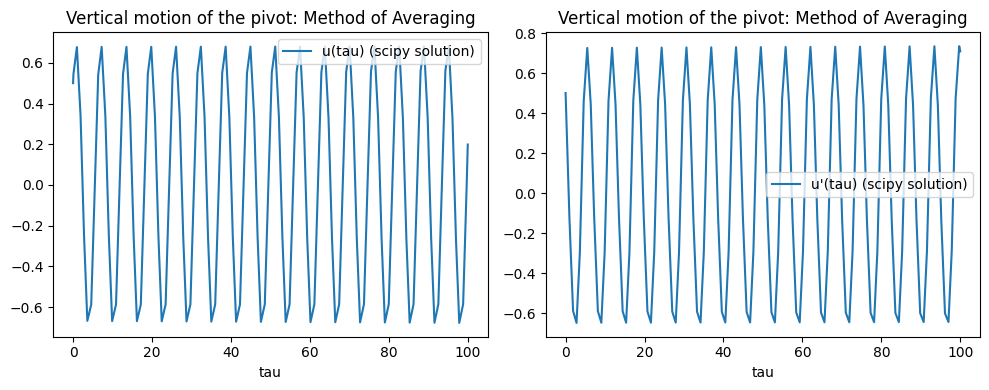

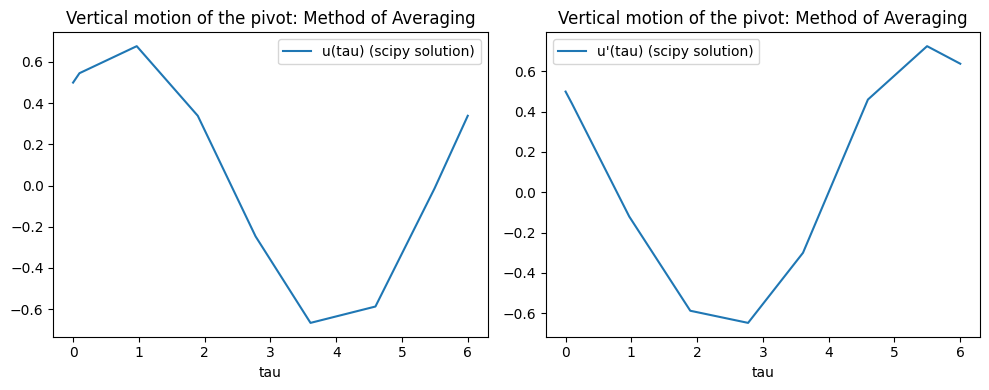

In [15]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, 3, lambd[0], epsilon[0]))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, 3, lambd[0], epsilon[0]))

##### Conclusions about $\Omega$ 


We observe that specifically at $\Omega=2$, the amplitude of the oscillatory behavior changes over time and for $\Omega=1$ and $\Omega=3$, this phenomenon is not observed.

#### Ratio between the effective length and amplitude of oscillation $\lambda$

##### $\lambda = 0.1$

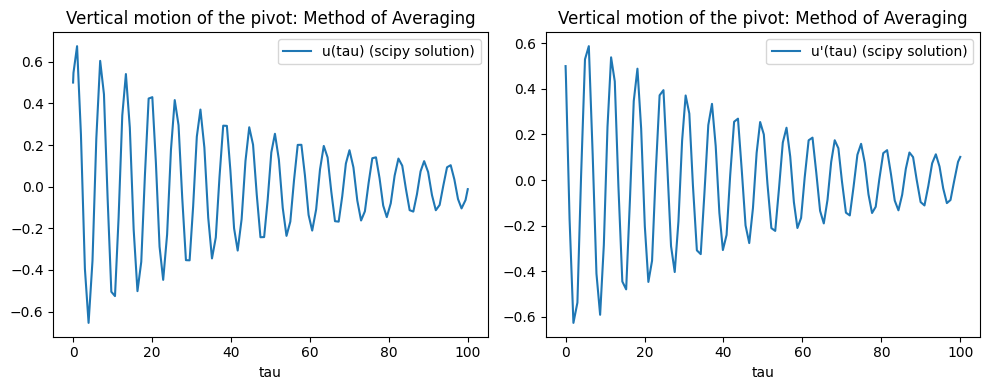

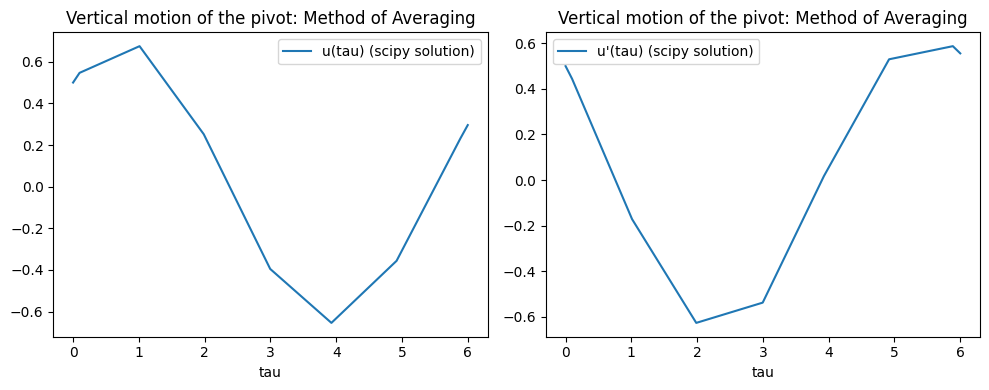

In [16]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, omega[0], 0.1, epsilon[0]))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, omega[0], 0.1, epsilon[0]))

##### $\lambda = 0.5$

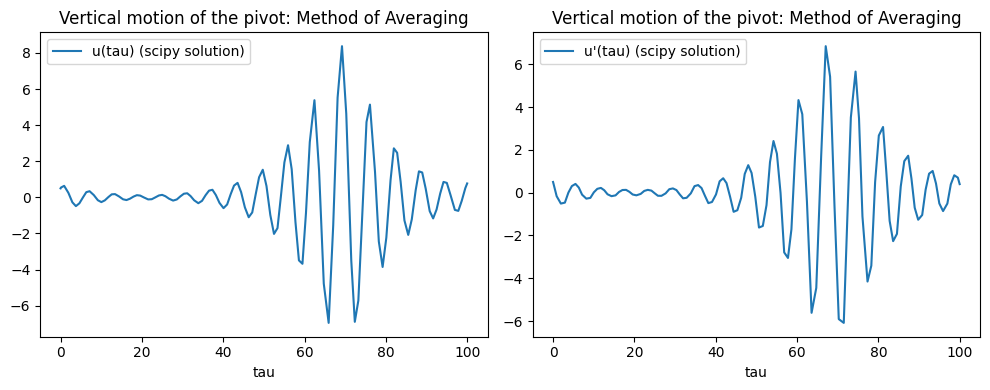

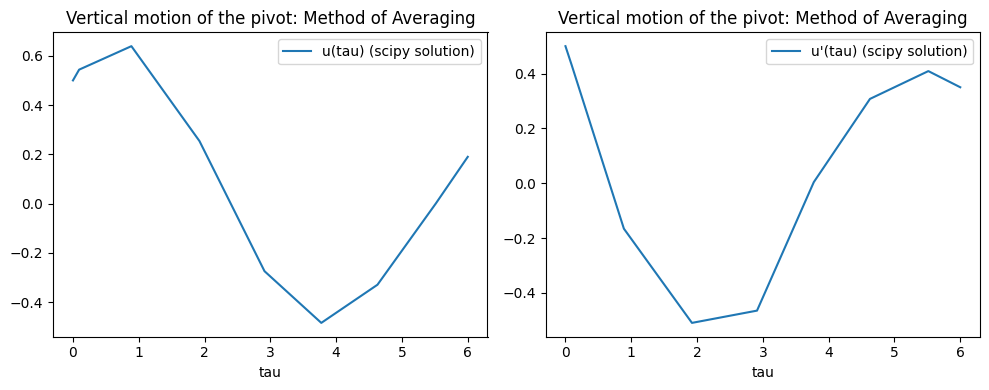

In [17]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, omega[0], 0.5, epsilon[0]))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, omega[0], 0.5, epsilon[0]))

##### Conclusions about $\lambda$

As $\lambda$ increases, the range of the function increases, and also has impact on the oscilatory behavior, this is suggested in the equation  

$$u'' + [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(u - \frac{\varepsilon^2 u^3}{6}\Big) = 0$$

Because $\lambda$ is a factor of the nonlinear term $\varepsilon \lambda \Omega^2 cos(\Omega \tau)$

> At $\lambda = 1$, for tau > 35, we start to see overflow errors  


#### Bookkeeping parameter $\varepsilon$

##### $\varepsilon = 0$

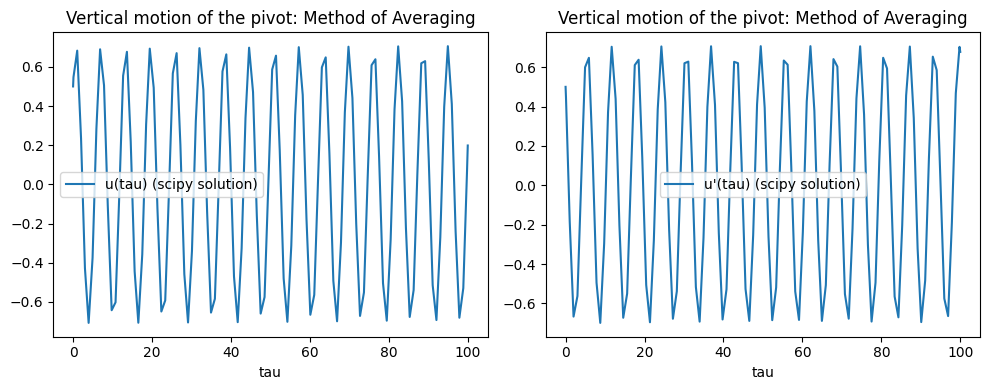

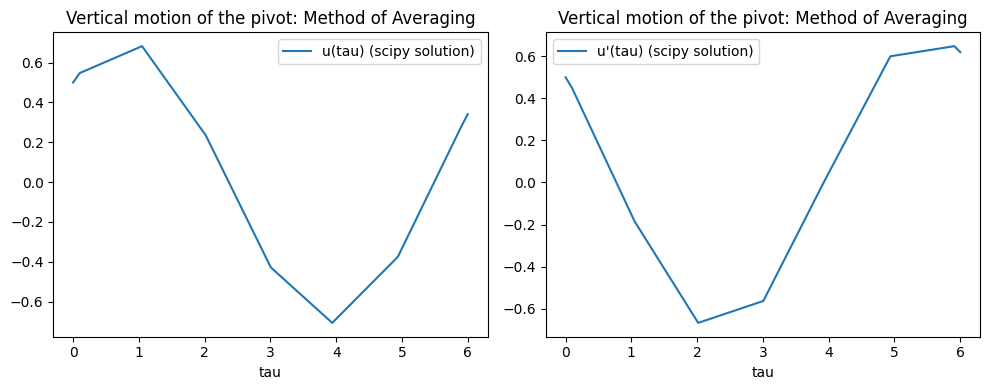

In [18]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, omega[0], lambd[0], 0))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, omega[0], lambd[0], 0))

$\varepsilon = 0.5$

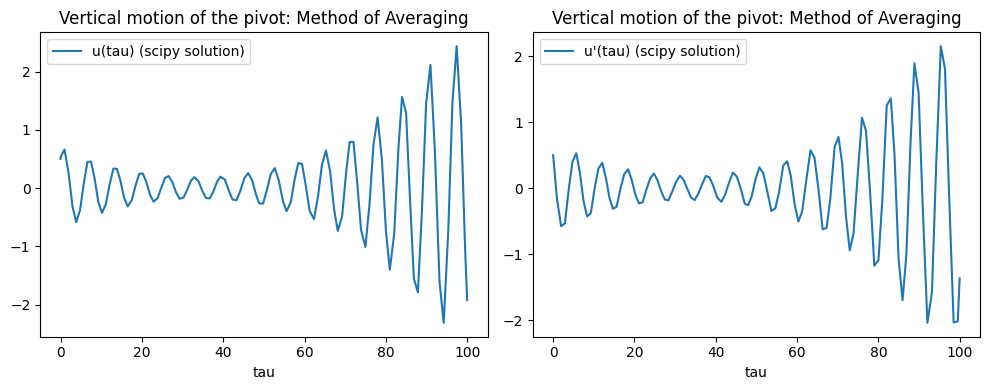

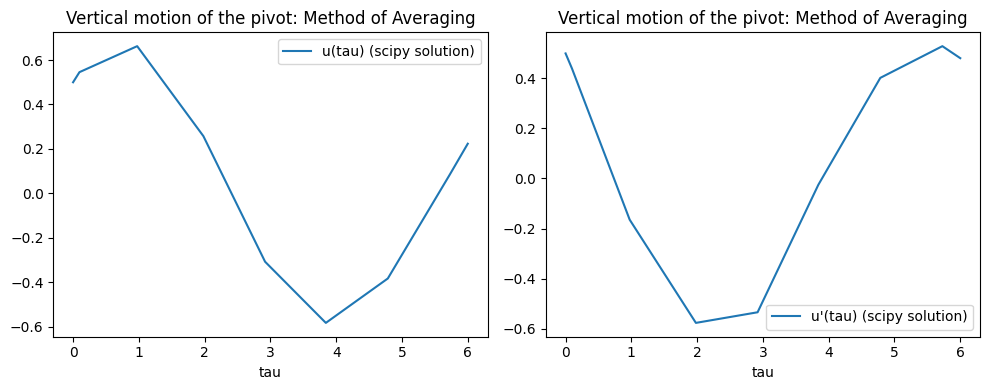

In [19]:
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_big, omega[0], lambd[0], 0.5))
graph_results(*solve_numerically(y1_0[0], y2_0[0], tau_l[0], tau_max_small, omega[0], lambd[0], 0.5))

##### Conclusions about $\varepsilon$

Like $\lambda$, as $\varepsilon$ increases, the range of the function increases, and also has impact on the oscilatory behavior, this is suggested in the equation  

$$u'' + [1 + \varepsilon \lambda \Omega^2 cos(\Omega \tau)]\Big(u - \frac{\varepsilon^2 u^3}{6}\Big) = 0$$

Because $\varepsilon$ is a factor of the nonlinear term $\varepsilon \lambda \Omega^2 cos(\Omega \tau)$ and  $\frac{\varepsilon^2 u^3}{6}$ 

### 6. Implement one additional numerical method, such as Euler, Modified Euler, or Heun.

#### Runge Kutta

In [20]:
def rungeKuttaStep(f, dt, t0, w0, *args):
    """
    Given wi aproximation, apply a runge kutta step to calculate w(i+1)
    
    Args:
        f (Callable) : the function f that where dy/dt = f(y, t)
        dt (float) : size of the step
        t0 (float) : current point at time, correspond to the time of wi
        w0 (float) : current approximation at time, note that w0 = wi
    
    Return:
        w(i+1) the next point in the integration
    """
    
    f1 = f(t0, w0, *args)
    f2 = f(t0 + (dt / 2), w0 + (dt / 2) * f1, *args)
    f3 = f(t0 + (dt / 2), w0 + (dt / 2) * f2, *args)
    f4 = f(t0 + dt, w0 + dt * f3, *args)

    return w0 + (dt / 6) * (f1 + 2*f2 + 2*f3 + f4)


def rungeKuttaSolver(system, initial_conditions, t0, t_max, dt, *args):
    """
    Solves a system of first-order ordinary differential equations (ODEs) using the 4th-order Runge-Kutta method.

    Args:
        system (Callable) : A function that represents the system of ODE, can be only one
        initial_conditions (list[float]) : [u_1(t0), u_2(t0), ..., u_m(t0)]   
        t0 (float) : initial value for the system
        t_max (float) : max value for the system
        dt (float) : size of each step in the integration

    Return:
        tuple:
            np.array : the values at which we are aproximatting
            np.array : 2D vector where the value at the i row, j col is the aproximation of u_i on t_j 
    """

    m = 1 if np.isscalar(initial_conditions) else len(initial_conditions)
    points = int((t_max - t0) / dt)
    
    t = np.zeros(points)
    y = np.zeros((m, points))

    y[:, 0] = initial_conditions
    t[0] = t0

    for i in range(points - 1):
        t[i + 1] = t[i] + dt
        y[:, i + 1] = rungeKuttaStep(system, dt, t[i], y[:, i], *args)

    return t, y

### 7. Compare your results with those obtained from solve ivp and discuss any discrepancies.

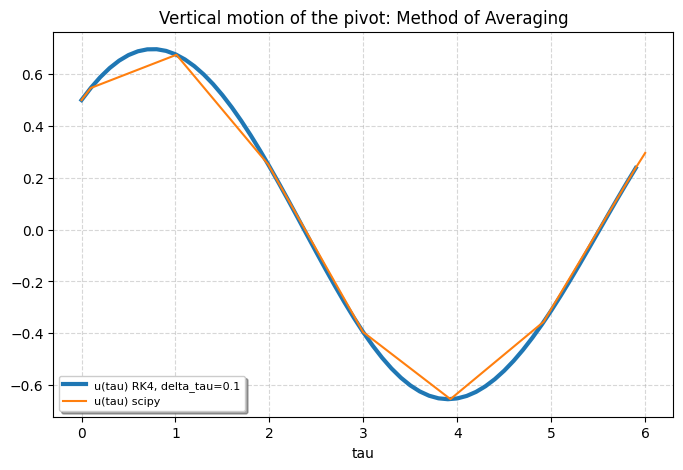

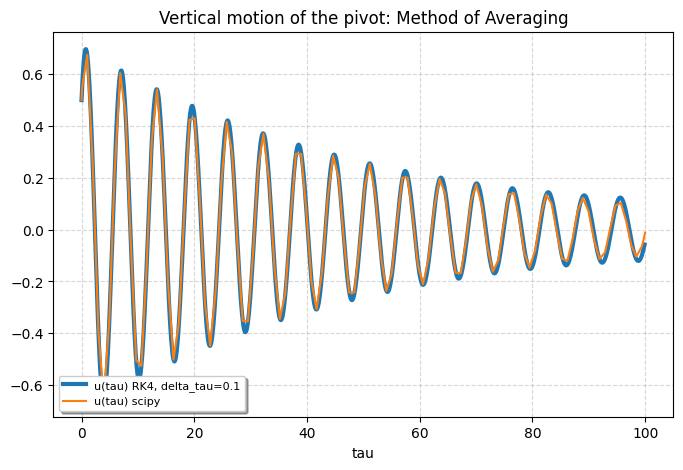

In [21]:
# PARAMETERS
initial_conditions = [y1_0[0], y2_0[0]]
tau_l_aux = 0
tau_r_values = [6, 100]
parameters = (omega[0], lambd[0], epsilon[0])
delta_tau = 0.1


for tau_r in tau_r_values:
    # SOLVE DIFFERENTIAL EQUATIONS
    scipy_sol = scipy.integrate.solve_ivp(vertical_motion, (tau_l_aux, tau_r), initial_conditions, args=(parameters)) # scipy solution
    tau, rk4_u = rungeKuttaSolver(vertical_motion, initial_conditions, tau_l_aux, tau_r, delta_tau, *parameters) # my solution
    scipy_u = scipy_sol.y
    scipy_tau = scipy_sol.t

    # PLOT AND COMPARE
    plt.figure(figsize=(8, 5))
    plt.plot(tau, rk4_u[0], label=f"u(tau) RK4, delta_tau={delta_tau}", linewidth=3) # u[0] refers to the 0 derivative of u, that means the u function itself
    plt.plot(scipy_tau, scipy_u[0], label="u(tau) scipy")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("tau")
    plt.title("Vertical motion of the pivot: Method of Averaging")
    plt.legend(loc="lower left", frameon=True, shadow=True, fontsize=8)
    plt.show()

Plot for different values for $\Delta \tau$

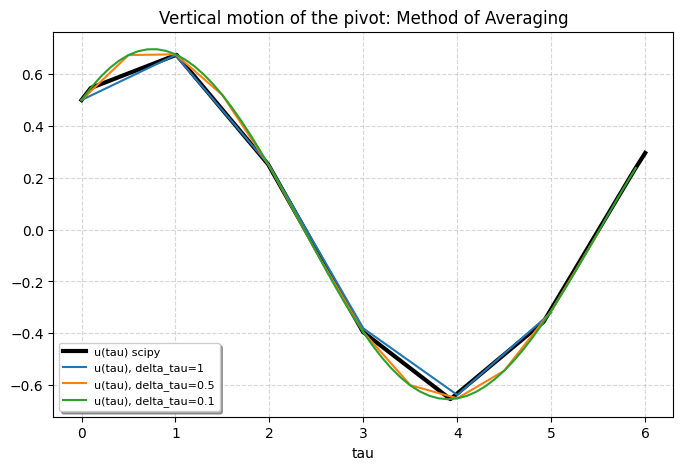

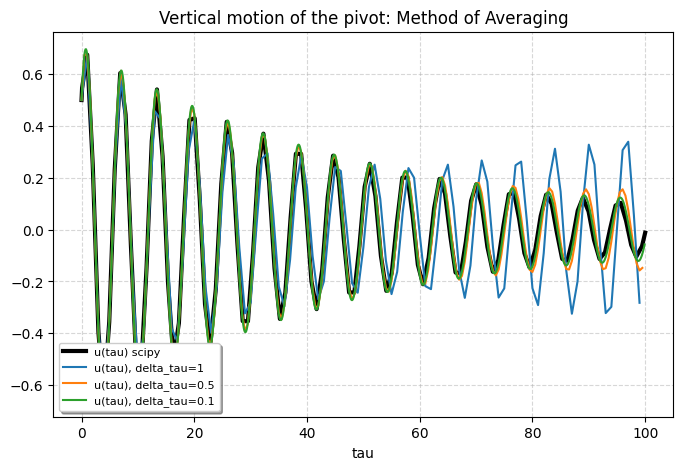

In [22]:
# PARAMETERS
initial_conditions = [y1_0[0], y2_0[0]]
tau_l_aux = 0
tau_r_values = [6, 100]
parameters = (omega[0], lambd[0], epsilon[0])
delta_tau_values = [1, 0.5, 0.1]

for tau_r in tau_r_values:
    # CREATE A NEW FIGURE FOR EACH TR
    plt.figure(figsize=(8, 5))

    # SOLVE DIFFERENTIAL EQUATIONS
    scipy_sol = scipy.integrate.solve_ivp(vertical_motion, (tau_l_aux, tau_r), initial_conditions, args=(parameters)) # scipy solution
    scipy_u = scipy_sol.y
    scipy_t = scipy_sol.t

    plt.plot(scipy_t, scipy_u[0], label="u(tau) scipy", linewidth=3, color="black") # PLOT SCIPY SOLUTION

    # SOLVE FOR EACH dt
    for delta_tau in delta_tau_values:
        tau, rk4_u = rungeKuttaSolver(vertical_motion, initial_conditions, tau_l_aux, tau_r, delta_tau, *parameters) # my solution
        plt.plot(tau, rk4_u[0], label=f"u(tau), delta_tau={delta_tau}") # PLOT delta_tau SOLUTION

    # PLOT OPTIONS
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("tau")
    plt.title("Vertical motion of the pivot: Method of Averaging")
    plt.legend(loc="lower left", frameon=True, shadow=True, fontsize=8)    
    plt.show()

#### Discussion about discrepances

As the last graph suggest, small values for $\Delta \tau$ show better precision. However, for excessively small values we should be aware about the computational cost and the truncation errors.

In this homework the value of $\Delta \tau = 0.1$ provides a good accuracy and effficiency, considering the domain for $\tau$ we choose.

## References

- [1] Guarín-Zapata, N. (2021). Sloshing in coffee as a pumped pendulum. arXiv preprint arXiv:2106.11435.
- [2] Ibrahim, R. A. (2005). Liquid sloshing dynamics: theory and applications. Cambridge University Press.